# Capacitated Vehicle Routing Problem (CVRP)

### Problem Definition
**What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?**

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/2b/Figure_illustrating_the_vehicle_routing_problem.png" alt="Centered Image" width="400">
</div>

- **Depot**: A central location where all vehicles **start** and **end** their routes.
- **Customers**: Locations that require deliveries. Each customer has a **known demand**.
- **Vehicles**: A fixed number of vehicles with a maximum carrying capacity.

### Constraints

- Every route starts and ends at the depot.
- Each customer must be visited exactly once by exactly one vehicle.
- The total demand on any route must not exceed the vehicle's capacity.

### Notation

- **N**: The set of customers.
- **K**: The set of vehicles.
- **C(i)**: The demand of customer $i$.
- **Q**: The capacity of each vehicle.
- **$d_{i, j}$**: The distance or cost from customer $i$ to customer $j$.
  
### Objective Function

Minimize the total distance traveled by all vehicles:

$$
\min \sum_{k \in K} \sum_{i \in N} \sum_{j \in N} d(i, j) x_{ij}^k
$$

where $(x_{ij}^k = 1)$ if vehicle $k$ travels from customer $i$ to customer $j$, and 0 otherwise.

### Constraints

1. Each vehicle must start and end at the depot:

$$
\sum_{i \in N} x_{0i}^k = 1 \quad \forall k \in K
$$

$$
\sum_{j \in N} x_{j0}^k = 1 \quad \forall k \in K
$$

2. Each customer must be visited exactly once:

$$
\sum_{k \in K} \sum_{i \in N} x_{ij}^k = 1 \quad \forall j \in N
$$

3. Vehicle capacity must not be exceeded:

$$
\sum_{i \in N} C(i) x_{ij}^k \leq Q \quad \forall k \in K
$$


# Any Colony Optimization

**How Ant Colony Optimization works ?**  
- In each iteraion, a fixed amount of ants leave the depot and find a feasible solution, the solution with the least travel distance is regarded as the best routeplan in this iteration.  
- The ant that found the best routeplan in an iteration leaves _pheromone_ on the route, and in the next iteration, the ant colony choose their route according to the pheromone density.

**How Does ant find its route ?**  
At each node, the ant choose the next node using a roulette based on transition probability $p_{ij}$  
$p_{ij}$ stands for the possibility of chossing node j at node i  
$$
p_{ij} = 
\begin{cases} 
\frac{(\tau_{ij})(\eta_{ij})^{\beta}}{\sum_{u \notin M_k} (\tau_{iu})(\eta_{iu})^{\beta}} & \text{if } j \notin M_k \\
0 & \text{otherwise}
\end{cases}
$$
$M_k$ stands for the already visited nodes set  
$\tau$ stands for the density of **_pheromones_**, for which the ant chooses the route with the higher density pheromones.  
$\eta_{ij}$ stands for the reciprocal of the distance between node i and j

**How does $\tau$ update ?**  
After finding a complete route, $\tau$ is updated by:  
$$\tau_{ij}^{new} = (1-\rho)\tau_{ij}^{old} + \Delta\tau_{ij}$$
$$\Delta\tau_{ij} = \frac{Q}{Travel \ Distance}$$

$\rho$ and $Q$ are predetermined parameters.

In [57]:
import math
import random
import copy
import matplotlib.pyplot as plt

In [58]:
# Distance of a specific route.
def node_distance(A,B):
    return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
# Calculate the distance matrix of all nodes
def distance_matrix(Nodes):
    n = len(Nodes)
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = node_distance(Nodes[i],Nodes[j])
    return matrix

1. Define class for customer(node) and vehicle(route)

In [59]:
class Node():
    def __init__(self,id,x,y,weight):
        self.id = id
        self.x = x
        self.y = y
        self.weight = weight

class Route():
    def __init__(self,start,Capacity):
        self.start = start
        self.Capacity = Capacity
        self.load = 0
        self.route = []
            
    def currentnode(self):
        if len(self.route) == 0:
            return self.start
        return self.route[-1]

    def addnode(self, node):
        self.route.append(node)
        self.load = self.load + node.weight

    def route_length(self): # must be non-empty
        length = 0
        length += node_distance(self.route[0],self.start)# Add the distance from the start to the first node
        for i in range(len(self.route)-1):
            length += node_distance(self.route[i],self.route[i+1])
        length += node_distance(self.route[-1],self.start)# Add the distance from the last node to the start node
        return length
        
    def Checkempty(self):
        if len(self.route) == 0:
            return False
        else:
            return True
        
class RoutePlan():
    def __init__(self, start, Capacity):
        self.start = start
        self.routeplan = []
        self.Capacity = Capacity
    
    def addroute(self,route):
        self.routeplan.append(route)

    def RP_distance(self):
        distance = 0
        for i in range(len(self.routeplan)):
            distance += self.routeplan[i].route_length()
        return distance
    
    def ReturnNodes(self):
        nodes = []
        for route in self.routeplan:
               for node in route.route:
                   nodes.append(node.id)
        return nodes
    
    def legitimate(self):
        self.routeplan = [route for route in self.routeplan if route.Checkempty()]

2. Genrate Nodes and Initial Solution

In [60]:
# Generate N customers with weights between MINweight and MAXweight
def Generate_Nodes(N,MINweight,MAXweight):
    Nodes = []
    data = list(set((random.randrange(900), random.randrange(600))for c in range(N)))
    for i in range(N):
        node_i = Node(i+1,data[i][0],data[i][1],random.randrange(MINweight,MAXweight))
        Nodes.append(node_i)
    return Nodes

# Generate a random route starting from the start node
def Initial_RP(start,Nodes,Capacity):
    nodes = copy.deepcopy(Nodes)
    RP = RoutePlan(start,Capacity)

    route = Route(start,Capacity)
    while nodes:
        node = random.choice(nodes)
        if route.load + node.weight <= Capacity:
            route.addnode(node)
            nodes.remove(node)
        else:
            RP.addroute(route)
            route = Route(start,Capacity)
    return RP


3. Update Next visit node and pheromone

In [61]:
# 1. Next Visit Set
def Next_Node_Set(route,unvisited,Nodes):
    next_node_set = [node for node in Nodes if node.id in unvisited and route.load + node.weight <= route.Capacity]
    return next_node_set

# 2. Next Visit node
def Next_node(route,next_node_set,Eta,Tau,alpha,beta):
    currentNode = route.currentnode() # if route is empty, currentNode is the start node by definition
    p_ij = [0 for i in range(len(next_node_set))]
    for j,node in enumerate(next_node_set):
        p_ij[j] = (Tau[currentNode.id][node.id])**alpha * (Eta[currentNode.id][node.id])**beta
    p_ij = [p/sum(p_ij) for p in p_ij]
    index = roulette(p_ij)
    return next_node_set.pop(index)

def roulette(p_ij):
    r = random.random() + 1e-10 # avoid r = 0 so that the start node can be selected
    for i in range(len(p_ij)):
        if sum(p_ij[:i+1]) >= r:
            return i
        
def updateTau(Tau,rho,Q,RP):
    delta_tau = Q/RP.RP_distance()
    Delta_tau = [[0 for i in range(len(Tau))] for j in range(len(Tau))]
    for route in RP.routeplan:
        Delta_tau[route.start.id][route.route[0].id] += delta_tau
        Delta_tau[route.route[0].id][route.start.id] += delta_tau

        for i in range(len(route.route)-1):
            Delta_tau[route.route[i].id][route.route[i+1].id] += delta_tau
            Delta_tau[route.route[i+1].id][route.route[i].id] += delta_tau

        Delta_tau[route.route[-1].id][route.start.id] += delta_tau
        Delta_tau[route.start.id][route.route[-1].id] += delta_tau

    for i in range(len(Tau)):
        for j in range(len(Tau)):
            Tau[i][j] = (1-rho)*Tau[i][j] + Delta_tau[i][j]
    return Tau

4. Plot Convergence curve and vehicle routes

In [62]:
def Plot(iterations,best_rp,start):
    # Plot Convergence Curve
    plt.plot(iterations)
    plt.xlabel('Iteration')
    plt.ylabel('Route Plan Distance')
    plt.title('Route Plan Distance over Iterations')
    plt.show()

    plt.plot(start.x,start.y,'ro',markersize=10)
    for route in best_rp.routeplan:
        x = [start.x] + [node.x for node in route.route] + [start.x]
        y = [start.y] + [node.y for node in route.route] + [start.y]
        plt.plot(x, y, marker='o')
    plt.title('CVRP Route')
    plt.show()

4. Main Function

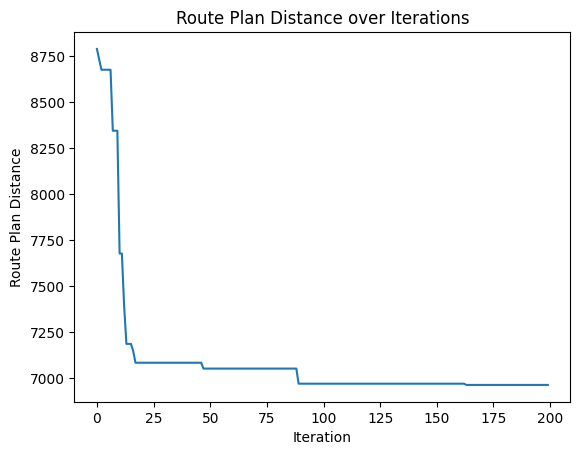

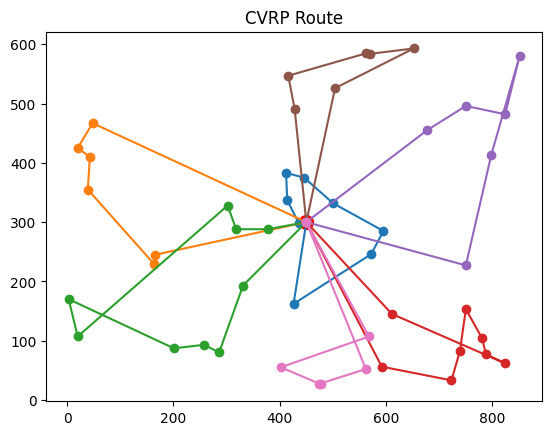

In [63]:
# 1. CVRP network parameters
N = 50     
other_Nodes = Generate_Nodes(N,10,50)
start = Node(0,450,300,0)
Nodes = [start] + other_Nodes
distance_matrix = distance_matrix(Nodes)
Capacity = 200

# 2. ACO parameters
m = 10 # number of ants
Q = 50
alpha = 1
beta = 3
eta = [[1/i if i != 0 else 0 for i in distance] for distance in distance_matrix]
rho = 0.7
Tau = [[1 for i in range(len(Nodes))] for j in range(len(Nodes))]

RP = RoutePlan(start,Capacity)

best = Initial_RP(start,other_Nodes,Capacity)
best_RP = []
# 3. ACO algorithm
max_iter = 200
for iter in range(max_iter):
    rps = []
    for i in range(m): # for each ant
        rp = copy.deepcopy(RP) # Initialize the route plan
        unvisited = list(range(1,N+1))

        route = Route(rp.start,rp.Capacity)
        while unvisited:
            next_node_set = Next_Node_Set(route,unvisited,Nodes)
            if not next_node_set:
                rp.routeplan.append(route)
                route = Route(rp.start,rp.Capacity)
                continue
            next_node = Next_node(route,next_node_set,eta,Tau,alpha,beta)
            route.addnode(next_node)
            unvisited.remove(next_node.id)

        rps.append(rp)

    best_rp = min(rps,key = lambda x : x.RP_distance()) #best route plan in the current iteration
    updateTau(Tau,rho,Q,best_rp)
    if best_rp.RP_distance() < best.RP_distance():
        best = best_rp
    best_RP.append(best)

iterations = [rp.RP_distance() for rp in best_RP]
best_rp = best_RP[-1]
Plot(iterations,best_rp,start)

**References:**  
[1]	"[Ant colony optimization techniques for the vehicle routing problem](https://www.sciencedirect.com/science/article/pii/S1474034604000060)," Advanced Engineering Informatics, vol. 18, no. 1, 2004/01/01, doi: 10.1016/j.aei.2004.07.001.